Somehow calculate the stability of training runs. This has to be improved

/tmp/ipykernel_3479396/453321565.py:44: RuntimeWarning: divide by zero encountered in arctanh
  group_W1_correls = np.arctanh(np.corrcoef(np.vstack(group['W1'])))
/tmp/ipykernel_3479396/453321565.py:45: RuntimeWarning: divide by zero encountered in arctanh
  group_W2_correls = np.arctanh(np.corrcoef(np.vstack(group['W2'])))


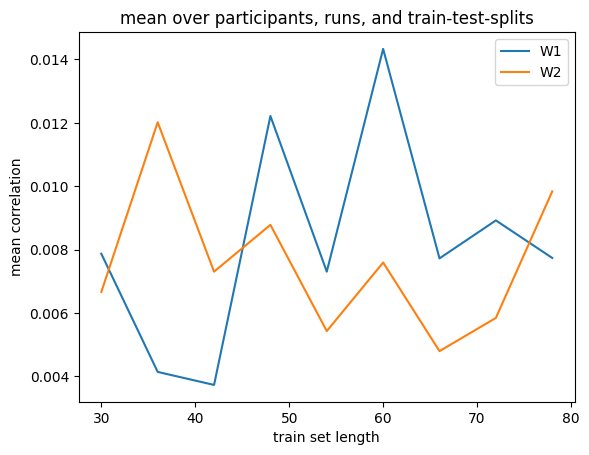

In [10]:
import os, sys
sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from eval_reallabor_utils import load_model_and_data, get_model_folders, get_hypers
import pickle

main_dir = '/home/janik.fechtelpeter/Documents/bptt/results/Reallabor1.0BestDaysNoInputsTrainLength3'
save_to = os.path.join(main_dir, '00_other_plots')
os.makedirs(save_to, exist_ok=True)
hyper = 'train_on_last_n_steps'

model_folders = get_model_folders(main_dir)
varied_hypers = list(get_hypers(main_dir, only_varying=True))
results = []

try:
    with open('W_matrices.pkl', 'rb') as pkl_file:
        results = pickle.load(pkl_file)
except:

    for f in tqdm(model_folders):
        try:
            model, data = load_model_and_data(f)
        except:
            1
            # print(f'error in path {f}')
        params = model.get_latent_parameters()
        res = pd.DataFrame({h: model.args[h] for h in varied_hypers}, index=[0])
        res['W1'] = [params[1].detach().numpy().flatten()]
        res['W2'] = [params[2].detach().numpy().flatten()]
        results.append(res)
    results = pd.concat(results, ignore_index=True)
    with open('W_matrices.pkl', 'wb') as pkl_file:
        pickle.dump(results, pkl_file)

varied_hypers.remove(hyper)

W1_correls = []
W2_correls = []
for name, group in results.groupby('name'):
    group_W1_correls = np.arctanh(np.corrcoef(np.vstack(group['W1'])))
    group_W2_correls = np.arctanh(np.corrcoef(np.vstack(group['W2'])))
    W1_correls.append(np.tanh(np.nanmean(group_W1_correls[np.triu_indices_from(group_W1_correls, k=1)])))
    W2_correls.append(np.tanh(np.nanmean(group_W2_correls[np.triu_indices_from(group_W2_correls, k=1)])))

results_by_name = results.groupby('name').first()
results_by_name['W1'] = W1_correls
results_by_name['W2'] = W2_correls
results_by_name.groupby(hyper)[['W1','W2']].mean().plot()
plt.xlabel('train set length')
plt.ylabel('mean correlation')
plt.title('mean over participants, runs, and train-test-splits')
plt.savefig(os.path.join(save_to, 'W_matrix_correlation_over_train_length.png'))